In [ ]:
# Figure: Optimality gap with respect of the iteration count (n). Varying the heterogeneity (eps het)

In [ ]:
pip install control

In [ ]:
import numpy as np
import numpy.random as rnd
import control
from control import dlqr
import matplotlib.pyplot as plt
import time
import random
import gc
from scipy.io import loadmat
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [ ]:
def perturbe_matrices(nominal, M, mask, epsilon):

    A = []
    for i in range(M):
        if i == 0:
          noise = 0
        else:
          noise = random.uniform(0, epsilon)
        A.append(nominal + mask*noise)


    return A


def grad_zo(A, B, Q, R, K, r, m):
    nx = A.shape[0]
    nu = B.shape[1]
    K1 = []
    K2 = []
    cost_1 = []
    cost_2 = []
    grad = np.zeros((nu, nx))
    Ul=[]
    for l in range(m):

        U = np.random.randn(B.shape[1], A.shape[0])
        U = (U / np.linalg.norm(U))* r

        K1.append(K + U)
        K2.append(K - U)

        # Compute cost
        x_0 = np.random.normal(0.5, 1e-3, size=(1,nx))[0]
        cost_1.append(lqr_cost(A, B, Q, R, K1[-1], x_0))
        cost_2.append(lqr_cost(A, B, Q, R, K2[-1], x_0))
        Ul.append(U)

    for l in range(m):
        grad += ((nx * nu) / (2 * m * (r ** 2))) * (cost_1[l] - cost_2[l]) * Ul[l]

    return grad


def local_step(K,eta_l,r,m,A,B,Q,R):

    #Estimate the gradient
    grad_estimate = grad_zo(A, B, Q, R, K, r, m)

    #One-step PG
    K_tilde = K - eta_l*grad_estimate


    return K_tilde - K #return model update


def lqr_cost(A, B, Q, R, K, x_0):
        T = 100
        PK = Q.copy()
        for t in range(T + 1):
            PK = Q + K.T @ R @ K + (A - B @ K).T @ PK @ (A - B @ K)
        cost = x_0 @ PK @ x_0
        return cost


def simulate(A, B, K, T, x_0):
        x_t = x0.copy()
        states = [x_t]
        controls = []
        for i in range(T):
            u_t = - K @ x_t
            controls.append(u_t)
            x_t = A @ x_t + B @ u_t
            states.append(x_t)
        return states

$\textbf{System matrices:}$

In [ ]:
#Nominal system matrices

A_0 = np.array([[ 1.22,  0.03, -0.02, -0.32],
              [ 0.01,  4.7 ,  0.  ,  0.  ],
              [ 0.02, -0.06,  0.4 ,  0.  ],
              [ 0.01, -0.04,  0.72,  1.55]])

B_0 = np.array([[ 0.01,  0.99],
              [-3.44,  1.66],
              [-0.83,  0.44],
              [-0.47,  0.25]])

#Modification patterns
A_tilde = np.diag([1,2,3,4])
B_tilde = np.ones((4,2))
Q_tilde = np.diag([2,2,2,2])
R_tilde = np.diag([2,2])

nx = A_0.shape[0]
nu = B_0.shape[1]

Q_0 = np.eye(nx)
R_0 = np.eye(nu)

x_0 = np.array([0.25,0.55,0.35,0.45])

#Generate M tuples (Ai,Bi,Qi,Ri) according to the heterogeneity level (eps_A,eps_B,eps_Q,eps_R)

M = 100

epsilon_A = 0.01
A = perturbe_matrices(A_0, M, A_tilde, epsilon_A)

epsilon_B = 0.01
B = perturbe_matrices(B_0, M, B_tilde, epsilon_B)

epsilon_Q = 0.01
Q = perturbe_matrices(Q_0, M, Q_tilde, epsilon_Q)

epsilon_R = 0.01
R = perturbe_matrices(R_0, M, R_tilde, epsilon_R)


#Checking the heterogeneity

norm_1 = []
norm_2 = []
norm_3 = []
norm_4 = []
for p in range(M):
    for s in range(M):
        norm_1.append(np.linalg.norm(A[p] - A[s]))
        norm_2.append(np.linalg.norm(B[p] - B[s]))
        norm_3.append(np.linalg.norm(Q[p] - Q[s]))
        norm_4.append(np.linalg.norm(R[p] - R[s]))

print(["eps_A=", max(norm_1)])
print(["eps_B=", max(norm_2)])
print(["eps_Q=", max(norm_3)])
print(["eps_R=", max(norm_4)])

['eps_A=', 0.054602794308271474]
['eps_B=', 0.02805350656949142]
['eps_Q=', 0.038772117516981286]
['eps_R=', 0.028213683899206716]


$\textbf{Initial Stabilizing Controller:}$

In [ ]:
K_opt_nominal,_,_ = dlqr(A_0, B_0, Q_0, R_0)
cost_opt_nominal = lqr_cost(A_0, B_0, Q_0, R_0, K_opt_nominal, x_0)

#Perturbing K_opt_nominal to generate an initial stabilizing controllers for all the M systems

K_0 = np.array([[ 0.33683197, -1.7417071 ,  0.15033713,  0.28966262],
               [ 0.68460759,  0.42031008, -0.28415275, -0.6531542 ]])
cost_init = lqr_cost(A_0, B_0, Q_0, R_0, K_0, x_0)

print(["cost_opt=", cost_opt_nominal])
print(["cost_init=", cost_init])

['cost_opt=', 2.7147945921976557]
['cost_init=', 4.062822450452139]


In [ ]:
print(["K0",K_0])

['K0', array([[ 0.33683197, -1.7417071 ,  0.15033713,  0.28966262],
       [ 0.68460759,  0.42031008, -0.28415275, -0.6531542 ]])]


In [ ]:
#Checking if K_0 stabilizes all the M systems
flag = 0
for i in range(M):
    if sum([abs_eig > 1 for abs_eig in abs(LA.eigvals(A[i] - B[i]@K_0))]):
        assert False
        flag = 1
if flag == 0:
    print("K0 stabilizes all M systems")

K0 stabilizes all M systems


$\textbf{Asynchronous LQR design:}$

In [ ]:
def async_LQR(A,B,Q,R,K_0,eta_l,eta_g,N,bs,r,m,x_0,stragglers,tau_max):

    #free up memory
    gc.collect()

    gap = []

    #Iteration and buffer counters:

    s = 0
    n = 0

    M = len(A)

    cost_init = lqr_cost(A[0], B[0], Q[0], R[0], K_0, x_0)
    K_opt_nominal,_,_ = dlqr(A[0], B[0], Q[0], R[0])
    cost_opt_nominal = lqr_cost(A[0], B[0], Q[0], R[0], K_opt_nominal, x_0)
    gap.append(cost_init - cost_opt_nominal)
    print(f"Iteration: {0}, Cost gap: {gap[0]}")



    #Initialize the server
    K = K_0

    #Initialize local controllers
    Ks = []
    for i in range(M):
        Ks.append(K)

    flag_done = np.zeros((M,2))
    Deltas = []


    for i in range(M):
        Deltas.append(local_step(Ks[i],eta_l,r,m,A[i],B[i],Q[i],R[i]))



    indices = []

    #free up memory
    gc.collect()


    #Each system has its own counter

    times =[]

    for n in range(N):
        times.append(n)


        start_time = time.time()

        if n%tau_max != 0 :

            Delta = np.zeros((nu,nx))
            s = 0
            for i in range(M):
                if i not in stragglers:
                  Delta += Deltas[i]
                  s += 1
                  if s == bs:
                    break

            #Aggregate:
            K = K + eta_g*(1/bs)*Delta
            cost = lqr_cost(A[0], B[0], Q[0], R[0], K, x_0)
            gap.append(cost - cost_opt_nominal)
            end_time = time.time()
            print(f"Iteration: {n+1}, Cost gap: {gap[-1]}, Time: {end_time - start_time}")




            #Send the new controller to the clients that participate in the update

            for i in range(M):
              if i not in stragglers:

                 Ks[i] = K
                 Deltas[i] = local_step(Ks[i],eta_l,r,m,A[i],B[i],Q[i],R[i])


        else:
            Delta = np.zeros((nu,nx))
            s = 0
            for i in range(len(stragglers)):
                  Delta += Deltas[stragglers[i]]
                  s += 1
                  if s == bs:
                    break
            for i in range(M):
                if i not in stragglers:
                  Delta += Deltas[i]
                  s += 1
                  if s == bs:
                    break

            #Aggregate:
            K = K + eta_g*(1/bs)*Delta
            cost = lqr_cost(A[0], B[0], Q[0], R[0], K, x_0)
            gap.append(cost - cost_opt_nominal)
            end_time = time.time()
            print(f"Iteration: {n+1}, Cost gap: {gap[-1]}, Time: {end_time - start_time}")



            #Send the new controller to the clients that participate in the update

            for i in range(len(stragglers)):
                 Ks[stragglers[i]] = K
                 Deltas[stragglers[i]] = local_step(Ks[stragglers[i]],eta_l,r,m,A[stragglers[i]],B[stragglers[i]],Q[stragglers[i]],R[stragglers[i]])


    return gap,K

$\textbf{Varying $\epsilon_{\text{het}}$}$:

In [ ]:
#Algorithm Parameters:

N = 100 #Number of iterations
eta_l = 1e-3 #local step-size
eta_g = 1e-2 #global step-size
r = 1e-2 #smoothing radius
m = 20 #number of trajectories
bs = 20 #buffer size

#number of seeds:
nseed = 1

M = 50 #number of systems

eps_tuple = [(0.001, 0.005, 0.001, 0.001)]

#Nominal system matrices

A_0 = np.array([[ 1.22,  0.03, -0.02, -0.32],
              [ 0.01,  4.7 ,  0.  ,  0.  ],
              [ 0.02, -0.06,  0.4 ,  0.  ],
              [ 0.01, -0.04,  0.72,  1.55]])

B_0 = np.array([[ 0.01,  0.99],
              [-3.44,  1.66],
              [-0.83,  0.44],
              [-0.47,  0.25]])

nx = A_0.shape[0]
nu = B_0.shape[1]

Q_0 = np.eye(4)
R_0 = np.eye(2)

x_0 = np.array([0.25,0.55,0.35,0.45])


#Max staleness
tau_max = 5

stragglers = random.sample(range(1, M), 20)

gap_mean_1 = []
gap_sd = []
gap_cint = []

for i in range(len(eps_tuple)):

    epsilon_A, epsilon_B, epsilon_Q, epsilon_R = eps_tuple[i]

    gap_seed = []
    for j in range(nseed):

        A = perturbe_matrices(A_0, M, A_tilde, epsilon_A)
        B = perturbe_matrices(B_0, M, B_tilde, epsilon_B)
        Q = perturbe_matrices(Q_0, M, Q_tilde, epsilon_Q)
        R = perturbe_matrices(R_0, M, R_tilde, epsilon_R)


        #Checking the heterogeneity

        norm_1 = []
        norm_2 = []
        norm_3 = []
        norm_4 = []
        for p in range(M):
            for s in range(M):
                norm_1.append(np.linalg.norm(A[p] - A[s]))
                norm_2.append(np.linalg.norm(B[p] - B[s]))
                norm_3.append(np.linalg.norm(Q[p] - Q[s]))
                norm_4.append(np.linalg.norm(R[p] - R[s]))

        print(["eps_A=", max(norm_1)])
        print(["eps_B=", max(norm_2)])
        print(["eps_Q=", max(norm_3)])
        print(["eps_R=", max(norm_4)])



        #free up memory
        gc.collect()
        gap, K_N = async_LQR(A,B,Q,R,K_0,eta_l,eta_g,N,bs,r,m,x_0,stragglers,tau_max)
        gap_seed.append(gap)


    gap_mean_1.append(np.mean(gap_seed,axis=0))
    gap_sd.append(np.std(gap_seed, axis = 0) / np.sqrt(len(gap_seed)))
    gap_cint.append(1.95*(np.std(gap_seed, axis = 0) / np.sqrt(len(gap_seed))))

['eps_A=', 0.005122508070718585]
['eps_B=', 0.01408796745011318]
['eps_Q=', 0.003708856889494072]
['eps_R=', 0.002812501672437564]
Iteration: 0, Cost gap: 1.3480278582544836
Iteration: 1, Cost gap: 1.2666392422773995, Time: 0.002468585968017578
Iteration: 2, Cost gap: 1.2386062395973534, Time: 0.0014011859893798828
Iteration: 3, Cost gap: 1.2120954954754808, Time: 0.001644134521484375
Iteration: 4, Cost gap: 1.183148536149706, Time: 0.0014586448669433594
Iteration: 5, Cost gap: 1.154849794640434, Time: 0.001430511474609375
Iteration: 6, Cost gap: 1.0935656404432832, Time: 0.0024819374084472656
Iteration: 7, Cost gap: 1.0706616026724642, Time: 0.0017614364624023438
Iteration: 8, Cost gap: 1.0498867857916534, Time: 0.0013952255249023438
Iteration: 9, Cost gap: 1.0319902933479534, Time: 0.0013885498046875
Iteration: 10, Cost gap: 1.012886180993796, Time: 0.0013878345489501953
Iteration: 11, Cost gap: 0.9661545402619174, Time: 0.0025861263275146484
Iteration: 12, Cost gap: 0.94847059270037

In [ ]:
#Algorithm Parameters:

N = 100 #Number of iterations
eta_l = 0.1e-3 #local step-size
eta_g = 0.1e-2 #global step-size
r = 1e-2 #smoothing radius
m = 20 #number of trajectories
bs = 20 #buffer size

#number of seeds:
nseed = 1

M = 50 #number of systems

eps_tuple = [(0.07, 0.05, 0.05, 0.1)]

#Nominal system matrices

A_0 = np.array([[ 1.22,  0.03, -0.02, -0.32],
              [ 0.01,  4.7 ,  0.  ,  0.  ],
              [ 0.02, -0.06,  0.4 ,  0.  ],
              [ 0.01, -0.04,  0.72,  1.55]])

B_0 = np.array([[ 0.01,  0.99],
              [-3.44,  1.66],
              [-0.83,  0.44],
              [-0.47,  0.25]])

nx = A_0.shape[0]
nu = B_0.shape[1]

Q_0 = np.eye(4)
R_0 = np.eye(2)

x_0 = np.array([0.25,0.55,0.35,0.45])


#Max staleness
tau_max = 5

stragglers = random.sample(range(1, M), 20)

gap_mean_2 = []
gap_sd = []
gap_cint = []

for i in range(len(eps_tuple)):

    epsilon_A, epsilon_B, epsilon_Q, epsilon_R = eps_tuple[i]

    gap_seed = []
    for j in range(nseed):

        A = perturbe_matrices(A_0, M, A_tilde, epsilon_A)
        B = perturbe_matrices(B_0, M, B_tilde, epsilon_B)
        Q = perturbe_matrices(Q_0, M, Q_tilde, epsilon_Q)
        R = perturbe_matrices(R_0, M, R_tilde, epsilon_R)


        #Checking the heterogeneity

        norm_1 = []
        norm_2 = []
        norm_3 = []
        norm_4 = []
        for p in range(M):
            for s in range(M):
                norm_1.append(np.linalg.norm(A[p] - A[s]))
                norm_2.append(np.linalg.norm(B[p] - B[s]))
                norm_3.append(np.linalg.norm(Q[p] - Q[s]))
                norm_4.append(np.linalg.norm(R[p] - R[s]))

        print(["eps_A=", max(norm_1)])
        print(["eps_B=", max(norm_2)])
        print(["eps_Q=", max(norm_3)])
        print(["eps_R=", max(norm_4)])



        #free up memory
        gc.collect()
        gap, K_N = async_LQR(A,B,Q,R,K_0,eta_l,eta_g,N,bs,r,m,x_0,stragglers,tau_max)
        gap_seed.append(gap)


    gap_mean_2.append(np.mean(gap_seed,axis=0))
    gap_sd.append(np.std(gap_seed, axis = 0) / np.sqrt(len(gap_seed)))
    gap_cint.append(1.95*(np.std(gap_seed, axis = 0) / np.sqrt(len(gap_seed))))

['eps_A=', 0.380547031132205]
['eps_B=', 0.14039689684112444]
['eps_Q=', 0.1977222519048314]
['eps_R=', 0.28045517813853815]
Iteration: 0, Cost gap: 1.3480278582544836
Iteration: 1, Cost gap: 1.1650902952083686, Time: 0.0015833377838134766
Iteration: 2, Cost gap: 1.0857846497397903, Time: 0.0013959407806396484
Iteration: 3, Cost gap: 1.0649207259021352, Time: 0.0014107227325439453
Iteration: 4, Cost gap: 1.052882496833388, Time: 0.0013883113861083984
Iteration: 5, Cost gap: 1.0423962368101005, Time: 0.0024499893188476562
Iteration: 6, Cost gap: 1.0128482511700558, Time: 0.0014476776123046875
Iteration: 7, Cost gap: 1.0036517730288366, Time: 0.0013844966888427734
Iteration: 8, Cost gap: 0.9964849124879924, Time: 0.0013549327850341797
Iteration: 9, Cost gap: 0.9881661006934337, Time: 0.0013704299926757812
Iteration: 10, Cost gap: 0.9791686509331292, Time: 0.001382589340209961
Iteration: 11, Cost gap: 0.9584658705240163, Time: 0.0016589164733886719
Iteration: 12, Cost gap: 0.9482346251042

In [ ]:
#Algorithm Parameters:

N = 100 #Number of iterations
eta_l = 1e-3 #local step-size
eta_g = 1e-2 #global step-size
r = 1e-2 #smoothing radius
m = 20 #number of trajectories
bs = 20 #buffer size

#number of seeds:
nseed = 1

M = 100 #number of systems


eps_tuple = [(0, 0, 0, 0)]

#Nominal system matrices

A_0 = np.array([[ 1.22,  0.03, -0.02, -0.32],
              [ 0.01,  4.7 ,  0.  ,  0.  ],
              [ 0.02, -0.06,  0.4 ,  0.  ],
              [ 0.01, -0.04,  0.72,  1.55]])

B_0 = np.array([[ 0.01,  0.99],
              [-3.44,  1.66],
              [-0.83,  0.44],
              [-0.47,  0.25]])

nx = A_0.shape[0]
nu = B_0.shape[1]

Q_0 = np.eye(4)
R_0 = np.eye(2)

A = []; B = []; Q = []; R = []
for i in range(M):
    A.append(A_0)
    B.append(B_0)
    Q.append(Q_0)
    R.append(R_0)


x_0 = np.array([0.25,0.55,0.35,0.45])


#Max staleness
tau_max = 2

stragglers = random.sample(range(1, M), 20)

gap_mean_3 = []
gap_sd = []
gap_cint = []

for i in range(len(eps_tuple)):

    epsilon_A, epsilon_B, epsilon_Q, epsilon_R = eps_tuple[i]

    gap_seed = []
    for j in range(nseed):

        #free up memory
        gc.collect()
        gap, K_N = async_LQR(A,B,Q,R,K_0,eta_l,eta_g,N,bs,r,m,x_0,stragglers,tau_max)
        gap_seed.append(gap)


    gap_mean_3.append(np.mean(gap_seed,axis=0))
    gap_sd.append(np.std(gap_seed, axis = 0) / np.sqrt(len(gap_seed)))
    gap_cint.append(1.95*(np.std(gap_seed, axis = 0) / np.sqrt(len(gap_seed))))

Iteration: 0, Cost gap: 1.3480278582544836
Iteration: 1, Cost gap: 1.1877411641292244, Time: 0.0018205642700195312
Iteration: 2, Cost gap: 1.1570525250895871, Time: 0.001767873764038086
Iteration: 3, Cost gap: 1.0401046886547851, Time: 0.0015659332275390625
Iteration: 4, Cost gap: 1.0210126522874843, Time: 0.0024881362915039062
Iteration: 5, Cost gap: 0.9359441324160223, Time: 0.0016260147094726562
Iteration: 6, Cost gap: 0.9198960411868029, Time: 0.0013728141784667969
Iteration: 7, Cost gap: 0.8455950036255007, Time: 0.0014820098876953125
Iteration: 8, Cost gap: 0.8316777547223415, Time: 0.0025217533111572266
Iteration: 9, Cost gap: 0.7726594678216392, Time: 0.0017762184143066406
Iteration: 10, Cost gap: 0.7609746940505251, Time: 0.0014002323150634766
Iteration: 11, Cost gap: 0.7144706069711564, Time: 0.0015139579772949219
Iteration: 12, Cost gap: 0.7062161636795867, Time: 0.002490997314453125
Iteration: 13, Cost gap: 0.6641470054842937, Time: 0.0015718936920166016
Iteration: 14, Cost

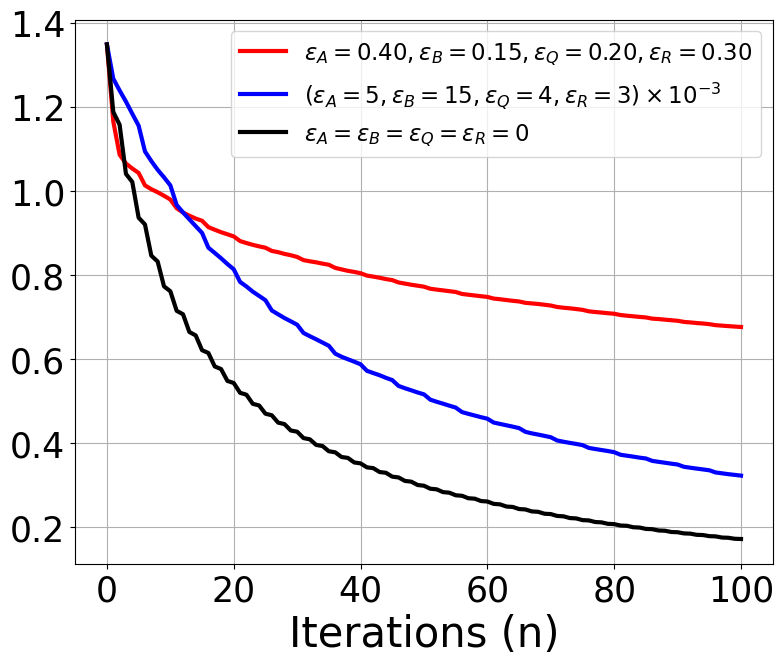

In [ ]:
#Plotting the results:

plt.figure(figsize=(9,8))


# Plotting the mean
colors = ['blue', 'red', 'black']
plt.plot(np.arange(N+1), gap_mean_2[0], label=r"$\epsilon_A = 0.40, \epsilon_B = 0.15, \epsilon_Q = 0.20, \epsilon_R = 0.30$", color="red", linewidth=3)
plt.plot(np.arange(N+1), gap_mean_1[0], label=r"$(\epsilon_A = 5, \epsilon_B = 15, \epsilon_Q = 4, \epsilon_R = 3)\times 10^{-3}$", color="blue", linewidth=3)
plt.plot(np.arange(N+1), gap_mean_3[0], label=r"$\epsilon_A = \epsilon_B = \epsilon_Q = \epsilon_R = 0$", color="black", linewidth=3)

plt.xlabel('Iterations (n)',fontsize=30)
plt.tick_params(axis='both', labelsize=25)

plt.legend(fontsize="16.5")
# Exclude the shading elements from the legend
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:len(labels)]  # Keep only the handles for the curve lines
labels = labels[:len(labels)]  # Keep only the labels for the curve lines

# Exclude the shading elements from the legend
plt.subplots_adjust(bottom=0.20)
plt.grid()
plt.savefig('het_opt_gap_arxiv.pdf')

When we have a smaller heterogeneity, we are able to afford larger step-sizes, this is because the aggregated PG is more accurate (lower variance). If we set a larger step-size when the heterogeneity is large it may produce non-stabilizing controllers. That is the reason why we set different step-sizes for different values of $ϵ_{het}$.